In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pickle
import math
import torch
from scipy import ndimage
import sys
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection')
from config import system as config_sys


In [3]:
# Save nested_dict dict as normal dict
subject_dict_path = f'{config_sys.project_data_root}/preprocessed'
# Open the saved dict
with open(os.path.join(subject_dict_path, 'inselspital_validation_dict.pkl'), 'rb') as f:
    loaded_dict = pickle.load(f)


In [4]:
# Path of the gradient images extracted from the centerline slicing for each test subject
seg_gradient_matching_path = f'{config_sys.project_code_root}/data/gradient_matching_seg'
gradient_matching_path = f'{config_sys.project_code_root}/data/gradient_matching'

# Path of the anomaly scores for each test subject
anomaly_score_experiment_path = f'{config_sys.project_code_root}/Results/Evaluation/vae_convT/masked_slice/20240518-2136_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse__SEED_5_2Dslice__without_rotation_with_cs_skip_updated_ao_S10_balanced_decreased_interpolation_factor_cube_3/test/outputs/'

# Path of the input images for each test subject
inputs_path = f'{config_sys.project_code_root}/Results/Evaluation/vae_convT/masked_slice/20240518-2136_vae_convT_masked_slice_SSL_lr1.000e-03-e1500-bs8-gf_dim8-daFalse__SEED_5_2Dslice__without_rotation_with_cs_skip_updated_ao_S10_balanced_decreased_interpolation_factor_cube_3/test/inputs/'

# Load the original image of the subject
original_image = np.load(f'{config_sys.project_data_root}/preprocessed/controls/numpy/MACDAVD_101_.npy')

subject_id = 33

# Load the gradient image, anomaly scores and input image for the selected subject
seg_gradient_matching_subject = os.listdir(seg_gradient_matching_path)[subject_id]
seg_gradient_matching_subject_path = os.path.join(seg_gradient_matching_path, seg_gradient_matching_subject)
seg_gradient_matching_image = np.load(seg_gradient_matching_subject_path)

# Load the gradient image, anomaly scores and input image for the selected subject
gradient_matching_subject = os.listdir(gradient_matching_path)[subject_id]
gradient_matching_subject_path = os.path.join(gradient_matching_path, gradient_matching_subject)
gradient_matching_image = np.load(gradient_matching_subject_path)

subject_name = seg_gradient_matching_subject_path.split('/')[-1].split('.npy')[0]
anomaly_score_experiment_subject = np.load(os.path.join(anomaly_score_experiment_path, f'{subject_name}_anomaly_scores.npy'))
anomaly_score_experiment_subject = np.transpose(anomaly_score_experiment_subject, (2,3,0,4,1))
anomaly_score_experiment_subject = np.repeat(anomaly_score_experiment_subject, 4, axis=-1)
input_subject = np.load(os.path.join(inputs_path, f'{subject_name}_inputs.npy'))
input_subject = np.transpose(input_subject, (1,2,0,3,4))



# Cut the image a bit from 32,32 to 28 28
gradient_matching_image = gradient_matching_image[2:-2,2:-2]
gradient_matching_image.shape, seg_gradient_matching_image.shape, anomaly_score_experiment_subject.shape, input_subject.shape


((28, 28, 64, 24, 4),
 (32, 32, 64, 24, 4),
 (32, 32, 64, 24, 4),
 (32, 32, 64, 24, 4))

(-0.5, 27.5, 27.5, -0.5)

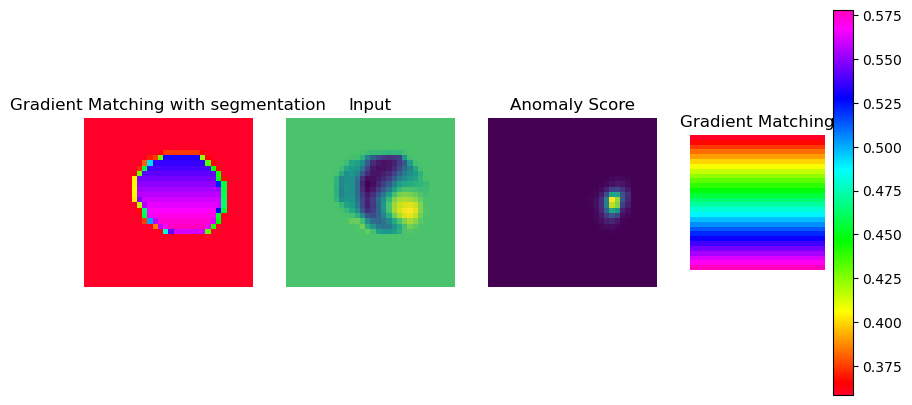

In [5]:
z_slice = 22
channel = 1
time_frame = 4

# Plot both images next to each other
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(seg_gradient_matching_image[:,:,z_slice,time_frame, channel], cmap ='gist_rainbow')
axs[0].set_title('Gradient Matching with segmentation')
axs[0].axis('off')
axs[1].imshow(input_subject[:,:,z_slice,time_frame, channel])
axs[1].set_title('Input')
axs[1].axis('off')
axs[2].imshow(anomaly_score_experiment_subject[:,:,z_slice,time_frame, channel])
axs[2].set_title('Anomaly Score')
axs[2].axis('off')
axs[3].imshow(gradient_matching_image[:,:,z_slice,time_frame, channel], cmap ='gist_rainbow')
axs[3].set_title('Gradient Matching')
# plot colorbar
fig.colorbar(axs[3].imshow(gradient_matching_image[:,:,z_slice,time_frame, channel], cmap ='gist_rainbow'), ax=axs[3])
axs[3].axis('off')

(-0.5, 27.5, 27.5, -0.5)

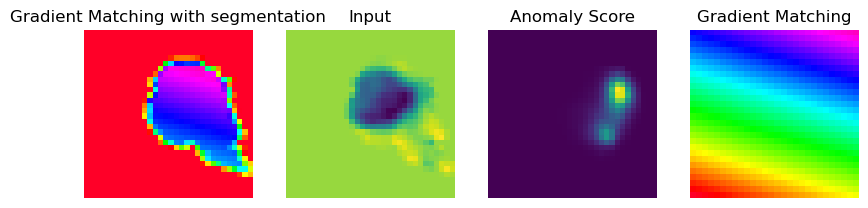

In [7]:
z_slice = 63
channel = 2
time_frame = 4

# Plot both images next to each other
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(seg_gradient_matching_image[:,:,z_slice,time_frame, channel], cmap ='gist_rainbow')
axs[0].set_title('Gradient Matching with segmentation')
axs[0].axis('off')
axs[1].imshow(input_subject[:,:,z_slice,time_frame, channel])
axs[1].set_title('Input')
axs[1].axis('off')
axs[2].imshow(anomaly_score_experiment_subject[:,:,z_slice,time_frame, channel])
axs[2].set_title('Anomaly Score')
axs[2].axis('off')
axs[3].imshow(gradient_matching_image[:,:,z_slice,time_frame, channel], cmap ='gist_rainbow')
axs[3].set_title('Gradient Matching')
axs[3].axis('off')

## Starting here, process of computing the axes from the gradients in extracted slices

In [8]:
oi = copy.deepcopy(gradient_matching_image)

# channel = 0 : gradient top-bottom
# channel = 1 : gradient front-back
# channel = 2 : gradient left-right



In [9]:
k1 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])  # Kernel for x differences
k0 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  # Kernel for y differences


ax_chans = [1,2] #AP,LR
ax_angles = []
ax_mags = []
z_slice_ex = 0
for ax_chan in ax_chans:
    #using a given slice (but would need to iterate over them)
    oi_sl = oi[:,:,z_slice_ex,time_frame,ax_chan]

    # Perform x convolution
    sob1=ndimage.convolve(oi_sl,k1)
    # Perform y convolution
    sob0=ndimage.convolve(oi_sl,k0)

    #get rid of vectors with gradient mag below tol
    tol = 1E-8
    sob0[np.abs(sob0)<tol] = 0.
    sob1[np.abs(sob1)<tol] = 0.

    sob_mag = np.sqrt((sob1 ** 2) + (sob0 ** 2))

    sob_ori = np.arctan2(-sob0, sob1) # radians
    #convert to degrees
    deg_sob_ori = np.rad2deg(sob_ori)

    ax_mags.append(np.mean(sob_mag))
    ax_angles.append(np.mean(sob_ori))

print(ax_mags,ax_angles)
print(ax_mags,np.rad2deg(ax_angles))

[0.06243948832200909, 0.03218651922664458] [-1.5707963267948966, 0.2815662523948013]
[0.06243948832200909, 0.03218651922664458] [-90.          16.13255792]


(-0.5, 27.5, 27.5, -0.5)

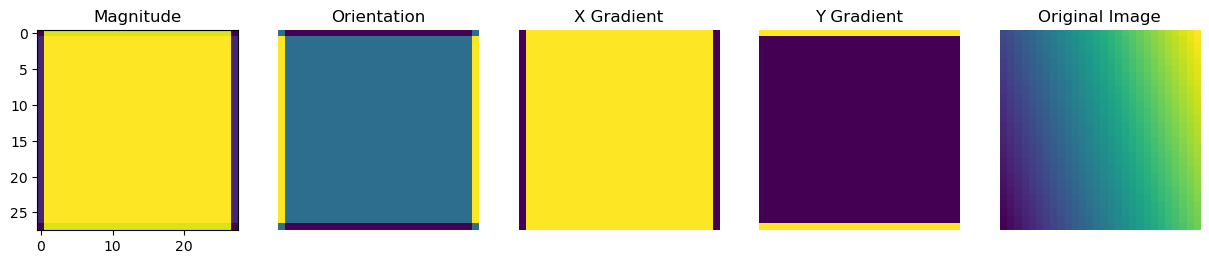

In [10]:
# plot 4 different images
fig, axs = plt.subplots(1, 5, figsize=(15, 8))
axs[0].imshow(sob_mag)
axs[0].set_title('Magnitude')
axs[1].imshow(sob_ori)
axs[1].set_title('Orientation')
axs[1].axis('off')
axs[2].imshow(sob1)
axs[2].set_title('X Gradient')
axs[2].axis('off')
axs[3].imshow(sob0)
axs[3].set_title('Y Gradient')
axs[3].axis('off')
axs[4].imshow(oi[:,:,z_slice_ex,time_frame, ax_chans[1]])
axs[4].set_title('Original Image')
axs[4].axis('off')



#### Create mask for quadrant based on angle

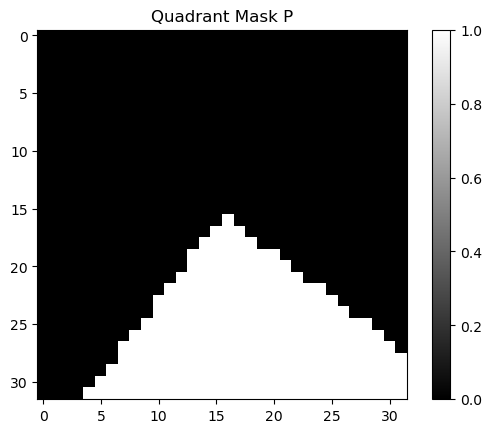

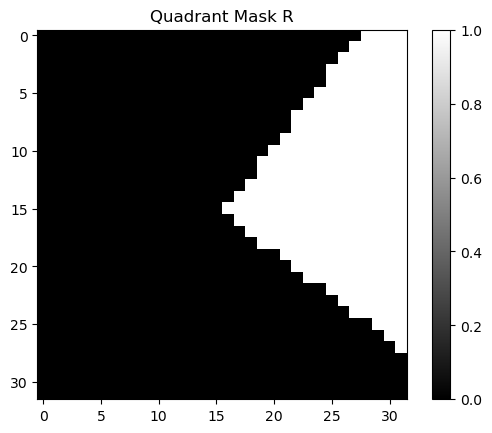

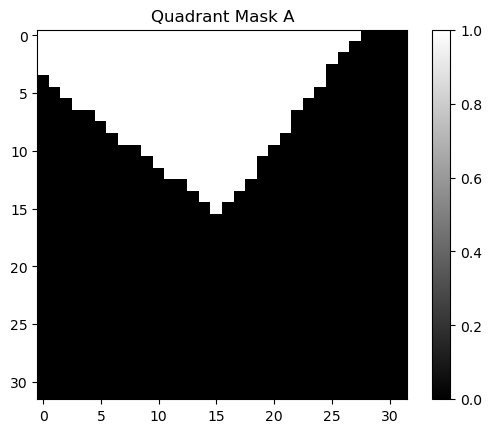

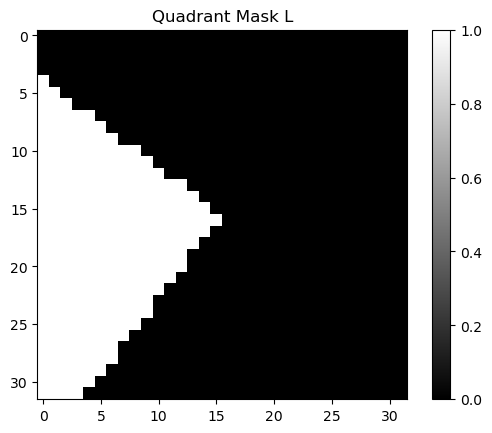

In [11]:

def compute_quadrant_mask_main_axes(ang, ang2):
    quad_mask = torch.zeros([1, 1, 32, 32])
    

    d1 = torch.linspace(1., -1., quad_mask.shape[-2])
    d2 = torch.linspace(-1., 1., quad_mask.shape[-1])
    d1v, d2v = torch.meshgrid(d1, d2, indexing='ij')

    for i in range(quad_mask.shape[-2]):
        for j in range(quad_mask.shape[-1]):
            cur_coor = torch.complex(d2v[i, j], d1v[i, j])
            ref_angle = torch.polar(torch.tensor(1.), torch.tensor(ang, dtype=torch.float32))
            ref_angle2 = torch.polar(torch.tensor(1.), torch.tensor(ang2, dtype=torch.float32))
            pi_angle = torch.polar(torch.tensor(1.), torch.tensor(math.pi, dtype=torch.float32))

            # Half angle diff between primary and secondary vectors
            cur_ref_diff = torch.angle(cur_coor * torch.conj(ref_angle))
            ref2_ref_diff = torch.angle(ref_angle2 * torch.conj(ref_angle)) / 2.
            ref2pi_ref_diff = torch.angle((ref_angle2 * pi_angle) * torch.conj(ref_angle)) / 2.

            # Given current point, check which axis is on the same side of the midpoint
            if torch.sign(cur_ref_diff) == torch.sign(ref2_ref_diff):
                closer_ref_diff = ref2_ref_diff
            else:
                closer_ref_diff = ref2pi_ref_diff

            if torch.abs(cur_ref_diff) < torch.abs(closer_ref_diff):
                quad_mask[0, 0, i, j] = 1

    return quad_mask

def create_all_quadrant_masks_main_axes(ax_angles):
    primary_angle = ax_angles[0]  # Anterior-Posterior
    secondary_angle = ax_angles[1]  # Left-Right

    # Quadrant: Posterior
    quad_mask_P = compute_quadrant_mask_main_axes(primary_angle, secondary_angle)

    # Quadrant: Right
    quad_mask_R = compute_quadrant_mask_main_axes(secondary_angle, primary_angle)

    # Quadrant: Anterior
    quad_mask_A = compute_quadrant_mask_main_axes(primary_angle + math.pi, secondary_angle + math.pi)

    # Quadrant: Left
    quad_mask_L = compute_quadrant_mask_main_axes(secondary_angle + math.pi, primary_angle + math.pi)

    quad_masks = [quad_mask_P, quad_mask_R, quad_mask_A, quad_mask_L]

    # Stack masks into a single tensor of shape [1, 4, 32, 32]
    combined_mask = torch.cat(quad_masks, dim=1)

    return combined_mask


masks_main_axes = create_all_quadrant_masks_main_axes(ax_angles)

# Display the masks
for idx in range(masks_main_axes.shape[1]):
    plt.figure()
    plt.imshow(masks_main_axes[0, idx], cmap='gray')
    plt.title(f'Quadrant Mask {["P", "R", "A", "L"][idx]}')
    plt.colorbar()
    plt.show()




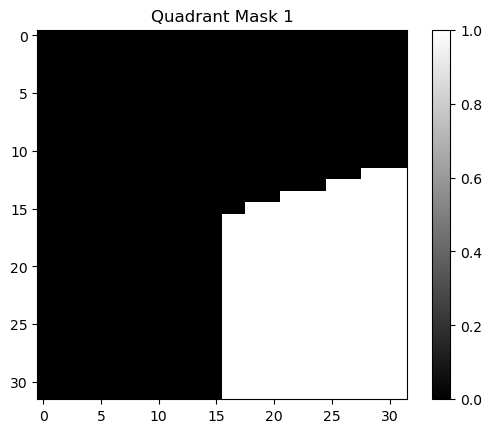

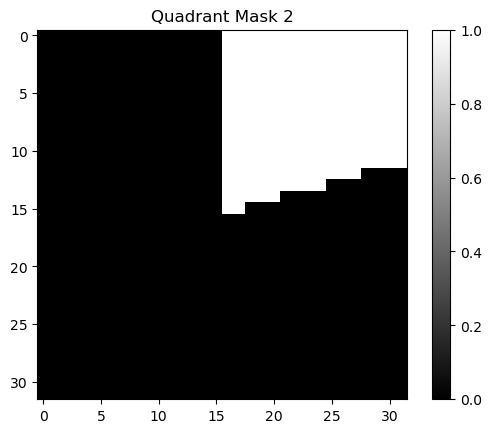

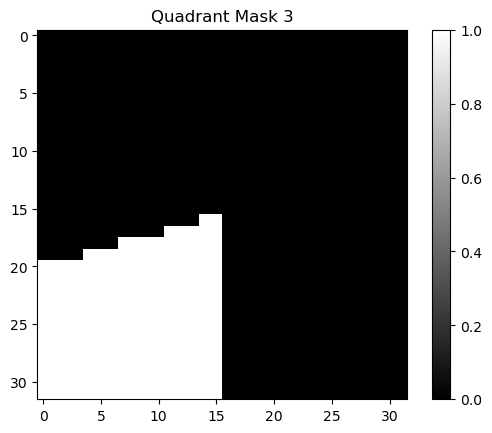

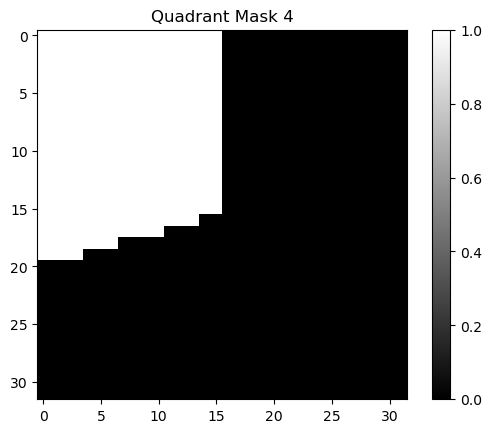

In [12]:
def normalize_angle(angle):
    return angle % (2 * math.pi)

def compute_single_quadrant_mask(ang, ang2):
    quad_mask = torch.zeros([32, 32])

    d1 = torch.linspace(1., -1., 32)
    d2 = torch.linspace(-1., 1., 32)
    d1v, d2v = torch.meshgrid(d1, d2, indexing='ij')

    for i in range(32):
        for j in range(32):
            cur_coor = torch.complex(d2v[i, j], d1v[i, j])
            ref_angle = torch.polar(torch.tensor(1.), torch.tensor(ang, dtype=torch.float32))
            ref_angle2 = torch.polar(torch.tensor(1.), torch.tensor(ang2, dtype=torch.float32))
        
            mid_angle = (ref_angle + ref_angle2) / 2.
            cur_mid_diff = torch.angle(cur_coor * torch.conj(mid_angle))
            ref_mid_diff = torch.angle(ref_angle * torch.conj(mid_angle))
            ref_mid_diff2 = torch.angle(ref_angle2 * torch.conj(mid_angle))
        
            if torch.sign(cur_mid_diff) == torch.sign(ref_mid_diff):
                closer_ref_diff = ref_mid_diff
            else:
                closer_ref_diff = ref_mid_diff2
            
            if torch.abs(cur_mid_diff) < torch.abs(closer_ref_diff):
                quad_mask[i, j] = 1

    return quad_mask

def compute_all_quadrant_masks_between_axes(ax_angles):
    primary_angle = ax_angles[0]
    secondary_angle = ax_angles[1]
    
    angles = [
        (primary_angle, secondary_angle),
        (primary_angle + math.pi, secondary_angle),
        (secondary_angle + math.pi, primary_angle),
        (primary_angle + math.pi, secondary_angle + math.pi)
    ]
    
    masks = [compute_single_quadrant_mask(a1, a2) for a1, a2 in angles]
    
    return torch.stack(masks).unsqueeze(0)

# Example angles
#ax_angles = [-math.pi / 2, 0]  # Replace with your actual angles

masks = compute_all_quadrant_masks_between_axes(ax_angles)

# Display the masks
for idx in range(masks.shape[1]):
    plt.figure()
    plt.imshow(masks[0, idx], cmap='gray')
    plt.title(f'Quadrant Mask {idx + 1}')
    plt.colorbar()
    plt.show()

# The resulting tensor 'masks' has shape (1, 4, 32, 32)
# The first quadrant mask is the posterior right quadrant
# The second quadrant mask is the anterior right quadrant
# The third quadrant mask is the posterior left quadrant
# The fourth quadrant mask is the anterior left quadrant

In [13]:
import os
import numpy as np
import copy
import logging
import torch
from scipy import ndimage

def get_zone_masks():
    # Path to the gradient images that went through the centerline preprocessing
    gradient_matching_path = f'{config_sys.project_code_root}/data/gradient_matching'
    gradient_matching_files = os.listdir(gradient_matching_path)
    gradient_matching_files.sort()

    # Dictionary to store results for each subject
    results = {}

    # Go through every gradient image 
    for gradient_matching_file in gradient_matching_files[:3]:
        subject_id = gradient_matching_file.split('.npy')[0]
        print(f'Processing {subject_id}')
        # Load the gradient image
        gradient_image = np.load(os.path.join(gradient_matching_path, gradient_matching_file))

        # Cut the image from 32x32 to 28x28 (Remove some parts that may be outside the body)
        gradient_image_original = gradient_image[2:-2, 2:-2]

        # Create a deep copy of the gradient image
        gradient_image = copy.deepcopy(gradient_image_original)

        k1 = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # Kernel for x differences
        k0 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # Kernel for y differences

        ax_chans = [1, 2]  # AP, LR

        subject_masks = []

        # Iterate over all slices
        for z_slice_ex in range(gradient_image.shape[2]):  # Assuming the 3rd dimension is slices
            print(f'Processing slice {z_slice_ex}')
            slice_masks = torch.zeros([1, 1, 32, 32])
            for ax_chan in ax_chans:
                ax_angles = []
                ax_mags = []
                oi_sl = gradient_image[:,:,z_slice_ex,time_frame,ax_chan]

                # Perform x convolution
                sob1 = ndimage.convolve(oi_sl, k1)
                # Perform y convolution
                sob0 = ndimage.convolve(oi_sl, k0)

                # Get rid of vectors with gradient mag below tol
                tol = 1E-8
                sob0[np.abs(sob0) < tol] = 0.
                sob1[np.abs(sob1) < tol] = 0.

                sob_mag = np.sqrt((sob1 ** 2) + (sob0 ** 2))
                sob_ori = np.arctan2(-sob0, sob1)  # radians

                ax_mags.append(np.mean(sob_mag))
                ax_angles.append(np.mean(sob_ori))

                # Creating the mask
                for angle in ax_angles:
                    tensor_angle = torch.tensor(angle, dtype=torch.float32)
                    quad_mask = torch.zeros([1, 1, 32, 32])
                    
                    d1 = torch.linspace(1., -1., quad_mask.shape[-2])
                    d2 = torch.linspace(-1., 1., quad_mask.shape[-1])
                    d1v, d2v = torch.meshgrid(d1, d2, indexing='ij')
                    
                    for i in range(quad_mask.shape[-2]):
                        for j in range(quad_mask.shape[-1]):
                            # Using complex number to compute angle difference
                            cur_coor = torch.complex(d2v[i, j], d1v[i, j])
                            ref_angle = torch.polar(torch.tensor(1.), tensor_angle)
                            ang_diff = torch.abs(torch.angle(cur_coor * torch.conj(ref_angle)))

                            if ang_diff <= math.pi / 4.:
                                quad_mask[0, 0, i, j] = 1
                    
                    subject_masks.append(quad_mask)

        # Store masks for the current subject
        results[gradient_matching_file] = {'masks': subject_masks}

    return results

# Call the function
results = get_zone_masks()


Processing MACDAVD_101_
Processing slice 0
Processing slice 1
Processing slice 2
Processing slice 3
Processing slice 4
Processing slice 5
Processing slice 6
Processing slice 7
Processing slice 8
Processing slice 9
Processing slice 10
Processing slice 11
Processing slice 12
Processing slice 13
Processing slice 14
Processing slice 15
Processing slice 16
Processing slice 17
Processing slice 18
Processing slice 19
Processing slice 20
Processing slice 21
Processing slice 22
Processing slice 23
Processing slice 24
Processing slice 25
Processing slice 26
Processing slice 27
Processing slice 28
Processing slice 29
Processing slice 30
Processing slice 31
Processing slice 32
Processing slice 33
Processing slice 34
Processing slice 35
Processing slice 36
Processing slice 37
Processing slice 38
Processing slice 39
Processing slice 40
Processing slice 41
Processing slice 42
Processing slice 43
Processing slice 44
Processing slice 45
Processing slice 46
Processing slice 47
Processing slice 48
Proces

In [16]:
import os
import numpy as np
import copy
import logging
import torch
from scipy import ndimage

def get_zone_masks():
    # Path to the gradient images that went through the centerline preprocessing
    gradient_matching_path = f'{config_sys.project_code_root}/data/gradient_matching'
    gradient_matching_files = os.listdir(gradient_matching_path)
    gradient_matching_files.sort()

    # Dictionary to store results for each subject
    results = {}

    # Go through every gradient image 
    for gradient_matching_file in gradient_matching_files[:3]:
        subject_id = gradient_matching_file.split('.npy')[0]
        print(f'Processing {subject_id}')
        # Load the gradient image
        gradient_image = np.load(os.path.join(gradient_matching_path, gradient_matching_file))

        # Cut the image from 32x32 to 28x28 (Remove some parts that may be outside the body)
        gradient_image_original = gradient_image[2:-2, 2:-2]

        # Create a deep copy of the gradient image
        gradient_image = copy.deepcopy(gradient_image_original)

        k1 = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # Kernel for x differences
        k0 = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # Kernel for y differences

        ax_chans = [1, 2]  # AP, LR

        # Initialize tensor to store masks for all slices
        subject_masks = torch.zeros((2, gradient_image.shape[2], 32, 32))

        # Iterate over all slices
        for z_slice_ex in range(gradient_image.shape[2]):  # Assuming the 3rd dimension is slices
            print(f'Processing slice {z_slice_ex}')
            for idx, ax_chan in enumerate(ax_chans):
                oi_sl = gradient_image[:, :, z_slice_ex, time_frame, ax_chan]

                # Perform x convolution
                sob1 = ndimage.convolve(oi_sl, k1)
                # Perform y convolution
                sob0 = ndimage.convolve(oi_sl, k0)

                # Get rid of vectors with gradient mag below tol
                tol = 1E-8
                sob0[np.abs(sob0) < tol] = 0.
                sob1[np.abs(sob1) < tol] = 0.

                sob_mag = np.sqrt((sob1 ** 2) + (sob0 ** 2))
                sob_ori = np.arctan2(-sob0, sob1)  # radians

                mean_angle = np.mean(sob_ori)
                tensor_angle = torch.tensor(mean_angle, dtype=torch.float32)
                
                d1 = torch.linspace(1., -1., 32)
                d2 = torch.linspace(-1., 1., 32)
                d1v, d2v = torch.meshgrid(d1, d2, indexing='ij')

                for i in range(32):
                    for j in range(32):
                        # Using complex number to compute angle difference
                        cur_coor = torch.complex(d2v[i, j], d1v[i, j])
                        ref_angle = torch.polar(torch.tensor(1.), tensor_angle)
                        ang_diff = torch.abs(torch.angle(cur_coor * torch.conj(ref_angle)))

                        if ang_diff <= np.pi / 4.:
                            subject_masks[idx, z_slice_ex, i, j] = 1

        # Store masks for the current subject
        results[subject_id] = subject_masks

    return results

# Call the function
results = get_zone_masks()


Processing MACDAVD_101_
Processing slice 0
Processing slice 1
Processing slice 2
Processing slice 3
Processing slice 4
Processing slice 5
Processing slice 6
Processing slice 7
Processing slice 8
Processing slice 9
Processing slice 10
Processing slice 11
Processing slice 12
Processing slice 13
Processing slice 14
Processing slice 15
Processing slice 16
Processing slice 17
Processing slice 18
Processing slice 19
Processing slice 20
Processing slice 21
Processing slice 22
Processing slice 23
Processing slice 24
Processing slice 25
Processing slice 26
Processing slice 27
Processing slice 28
Processing slice 29
Processing slice 30
Processing slice 31
Processing slice 32
Processing slice 33
Processing slice 34
Processing slice 35
Processing slice 36
Processing slice 37
Processing slice 38
Processing slice 39
Processing slice 40
Processing slice 41
Processing slice 42
Processing slice 43
Processing slice 44
Processing slice 45
Processing slice 46
Processing slice 47
Processing slice 48
Proces

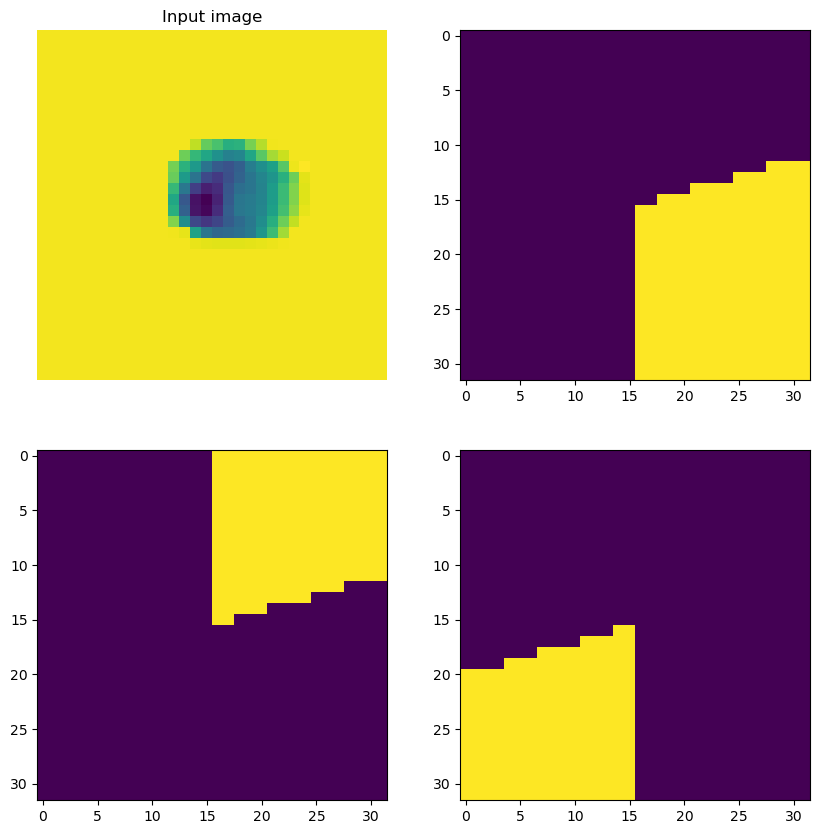

In [15]:
anomaly_score_experiment_test = np.load(os.path.join(anomaly_score_experiment_path, f'{subject_name}_anomaly_scores.npy'))
anomaly_score_experiment_test.shape
mask_quadrants = np.load(f'{config_sys.project_code_root}/data/quadrants_between_axes/{subject_name}_between_axes_masks.npy')
# Order: Posterior-right, Anterior-right, Posterior-left, Anterior-left
mask_quadrants.shape ,subject_name

z_slice = 0

plt.figure(figsize=(10, 10))
# Plot mask and input
plt.subplot(2, 2, 1)
plt.imshow(input_subject[:,:,z_slice,3,1])
plt.title('Input image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mask_quadrants[z_slice,0,:,:])

plt.subplot(2, 2, 3)
plt.imshow(mask_quadrants[z_slice,1,:,:])

plt.subplot(2, 2, 4)
plt.imshow(mask_quadrants[z_slice,2,:,:])





